<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_8_Model_selection_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 8. Выбор модели и регуляризация. Основы feature engineering.
----------

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
from matplotlib.patches import Patch
sns.set()

## Загрузка набора данных и разведочный анализ

Описание набора данных: https://www.kaggle.com/johnjyjy/microchip-quality-control/

Этот набор данных содержит информацию о 118 микрочипах, их результаты по двум тестам контроля качества (две числовые переменные) и информацию о том, пошел ли микрочип в производство (целевая переменная, `1` либо `0`).

**Цель:** предсказать, пошел ли чип в производство или нет, на основе двух тестов контроля качества.


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/microchip.txt', header=None, names = ('test1','test2','released'))
data.head()

**Стандартный разведовочный анализ данных**

In [ ]:
# getting some info about dataframe
data.info()

In [ ]:
data.describe()

In [ ]:
plt.figure()
sns.boxplot(data=data[['test1','test2']])
plt.title('Distribution of features scores')
plt.xlabel('features')
plt.show()

In [ ]:
data.head(5)

# Визуализация данных

Для удобства сконвертируем признаки и метки целевых классов в отдельные массивы NumPy.

In [ ]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

In [ ]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips')
plt.legend();

Функция для отрисовки разделяющей кривой (зависит от предсказаний модели)

In [ ]:
def plot_boundary(clf, X, y, grid_step=.005, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

# Полиномиальные признаки

Одним из способов решения этой задачи будет преобразование исходных признаков в новые признаки, например, в полиномиальные признаки. Затем мы сможем применить линейную регрессию к такому преобразованному набору признаков и получить нелинейную разделяющую границу между классами в исходном пространстве признаков.

Определим полиномиальные признаки степени $d$ для двух переменных $x_1$ и $x_2$:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} = \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

Например, для $d=3$ это будут следующие признаки:

$$\large 1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Число таких функций быстро растёт с ростом числа исходных признаков и с ростом $d$, и построение полиномиальных функций большой степени (например, $d=10$) для 100 переменных может быть вычислительно дорогим. Более того, в этом редко есть необходимость.

Можно поручить `sklearn` полиномиальное преобразования признаков, вызвав метод `PolynomialFeatures`. Итак, создадим объект, который будет добавлять полиномиальные признаки вплоть до степени 7 к исходной матрице признаков $X$.

Больше о feature engineering можно посмотреть здесь: https://github.com/PacktPublishing/Python-Feature-Engineering-Cookbook

In [ ]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [ ]:
X.shape

In [ ]:
X_poly.shape

Нахождение решения для обыкновенной регрессии сводится к: $$\hat{\beta}_{\mathrm{OLS}} = (X^TX)^{-1}X^Ty;$$
$$\hat{y} = X\hat{\beta}_{\mathrm{OLS}}$$

# Ridge-регрессия

Ridge-регрессия или гребневая регрессия очень похожа на обыкновенную регрессию, за исключением того, что коэффициенты в Ridge регрессии оцениваются путем минимизации немного другой функции:

$$J(X, y, \beta) = \mathcal{L} + \lambda \sum_j\beta_j^2$$

Где:
- $\mathcal{L}$ - функция потерь наименьших квадратов, просуммированная по всему набору данных
- $\lambda \sum_j\beta_j^2$ - штраф $l_2$
- $\lambda ≥ 0$ - настроечный параметр.

Как и в случае с обыкновенной регрессией, Ridge-регрессия оценивает коэффициенты, при которых минимизируется сумма квадратов остатков (RSS). Однако, второй член, $\lambda |\beta|^2$, называемый *штраф за усадку*, мал, когда $\beta_j$ близко к нулю, и поэтому $\beta_j$ занижается. Параметр настройки $\lambda$ служит для управления
влияния этого эффекта на оценку коэффициентов регрессии. Когда $\lambda = 0$, штрафной член не оказывает никакого влияния, и оценка Ridge-регрессии совпадает с оценкой по методу наименьших квадратов. Однако с увеличением $\lambda$ влияние штрафа за усадку растет, и оценки коэффициентов Ridge-регрессии приближаются к нулю.

Нахождение решения для Ridge-регрессии:

$$\hat{\beta}_{\text{Ridge}} = (X^TX + \lambda I)^{-1}X^Ty$$
$$\hat{y} = X\hat{\beta}_{\text{Ridge}}$$

Для логистической регрессии обычно вводят обратный коэффициент регуляризации $C=\frac{1}{\lambda}$.

# Первые эксперименты с Ridge-регрессией

Давайте построим несколько Ridge-регрессий с различными $C = [0.01, 0.5, 1,100, 1000, 10000]$, чтобы получить представление, как параметр влияет на модель.




In [ ]:
# X_poly[:, 1:] = (X_poly[:, 1:] - X_poly[:, 1:].mean(axis=0, keepdims=True)) / X_poly[:, 1:].std(axis=0, keepdims=True)

In [ ]:
Cs = [1e-2, 0.5, 1, 100, 1000, 10000]
for C in Cs:
    logit = LogisticRegression(C=C, penalty = 'l2', random_state=17)
    logit.fit(X_poly, y)
    print('C = ', C)
    print("Accuracy on training set:",
          round(logit.score(X_poly, y), 3))

    plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.title('2 tests of microchips. Logit with C=%s' % C)
    plt.legend()
    plt.show()
    print('\n\n\n')


Давайте перепишем функцию, которая оптимизируется в логистической регрессии, в виде:

$$J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

где:
- $\mathcal{L}$ - логистическая функция потерь, суммированная по всему набору данных
- $C$ - обратный коэффициент регуляризации

При больших значениях $C$ логистическая регрессия не будет "понимать" (или "учиться"), какое значение $C$ выбрать, как это происходит с весами $w$. То есть оно не может быть определено путем решения задачи оптимизации в логистической регрессии. Мы уже сталкивались с подобной ситуацией, когда решающее дерево не может "выбрать", какую предельную глубину выбрать в процессе обучения. Поэтому $C$ - это гиперпараметр модели, который настраивается на кросс-валидации, как и `max_depth` в дереве.

# Настройка параметров регуляризации

Для того чтобы найти наилучшее значение параметра $C$, мы будем использовать кросс-валидацию.

# Поиск гиперпараметра C по сетке

Определим оптимальное значение параметра регуляризации $C$. Это можно сделать с помощью `LogisticRegressionCV` - сеточного поиска параметров с последующей кросс-валидацией. Этот класс разработан специально для логистической регрессии (эффективные алгоритмы с известными параметрами поиска). Для произвольной модели используйте `GridSearchCV`, `RandomizedSearchCV` или специальные алгоритмы оптимизации гиперпараметров, например, реализованные в библиотеке [hyperopt](http://hyperopt.github.io/hyperopt/).

In [ ]:
c_values = np.logspace(-2, 3, 500)
c_values

In [ ]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 4, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

In [ ]:
type(skf)

In [ ]:
print('Best C = ', logit_searcher.C_[0])

Чтобы увидеть, как качество модели (процент правильных ответов на тренировочной и тестовой выборках) меняется в зависимости от гиперпараметра $C$, построим соответствующий график.

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Mean CV-accuracy');

# Модель для лучшего C

In [ ]:
C = 123
logit = LogisticRegression(C=C, random_state=17, penalty = 'l2')
logit.fit(X_poly, y)
print('C = ', C)
print("Accuracy on training set:",
      round(logit.score(X_poly, y), 3))

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend()
plt.show()
print('\n\n\n')


**Наилучшиее коэффициенты Ridge-регрессии**

In [ ]:
X_poly.shape

In [ ]:
print(logit.coef_)

In [ ]:
coefs = (logit.coef_)[0]

plt.figure(figsize=(10, 7))
sns.barplot(y=coefs, x=list(range(len(coefs))))
plt.title('Ridge regression beta coefficients vizualized')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.show()

# Lasso-регрессия
LASSO = Least Absolute Shrinkage and Selection Operator

У Ridge-регрессии есть один очевидный недостаток. Она не производит отбор признаков. Ridge-регрессия непременно будет включать все $p$ предикторов в окончательную модель. Штраф $\lambda |\beta|^2$ уменьшит все коэффициенты до нуля, но не установит ни один из них точно в ноль. Это может не быть проблемой для точности предсказания, но может создать трудности при интерпретации модели в условиях, когда число переменных $p$ довольно велико.

Lasso - это альтернатива Ridge-регрессии, которая преодолевает этот недостаток. Lasso минимизирует следующую функцию:

$$J(X, y, \beta) = \mathcal{L} + \lambda \sum_j|\beta_j|$$

- $\mathcal{L}$ - логистическая функция потерь, просуммированная по всему набору данных
- $\lambda \sum_j|\beta_j|$ называется штрафом $l_1$.

Lasso и Ridge-регрессия имеют схожие формулировки. Разница лишь в том, что член $\lambda\sum_j\beta_j^2$ в штрафе Ridge-регрессии заменен на $\lambda\sum_j|\beta_j|$ в штрафе Lasso.

Как и в случае с Ridge-регрессией, Lasso уменьшает оценки коэффициентов до нуля. Однако в случае Lasso, штраф имеет эффект обнуления некоторых оценок коэффициентов, если параметр настройки $\lambda$ достаточно велик. Следовательно, Lasso подходит для *выбора (важных, необходимых) переменных*.

# Первые эксперименты с Lasso-регрессией
Повторим те же эксперименты для Lasso-регрессии и построим несколько моделей с различными $C = [0.01, 0.5, 1,100, 1000, 10000]$.

In [ ]:
Cs = [0.01, 0.5, 1, 100, 1000, 10000]
for C in Cs:
    logit = LogisticRegression(C=C, penalty = 'l1', random_state=17, solver='liblinear')
    logit.fit(X_poly, y)
    print('C = ', C)
    print("Accuracy on training set:",
          round(logit.score(X_poly, y), 3))

    plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.title('2 tests of microchips. Logit with C=%s' % C)
    plt.legend()
    plt.show()
    print('\n\n\n')


Похожий вывод: для больших значений параметра регуляризации мы получаем более сложную границу между классами.

# Поиск по сетке

Применим ту же стратегию (поиск по сетке и кросс-валидацию) для нахождения оптимального $C$.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 1, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1, penalty = 'l1',  solver='liblinear')
logit_searcher.fit(X_poly, y)

In [ ]:
print('Best C = ', logit_searcher.C_[0])

**Кривая обучения**

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

# Поиск лучшей модели для Lasso-регрессии



In [ ]:
C = logit_searcher.C_[0]
logit = LogisticRegression(C=C, random_state=17, penalty = 'l2')
logit.fit(X_poly, y)
print('C = ', C)
print("Accuracy on training set:",
      round(logit.score(X_poly, y), 3))

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend()
plt.show()
print('\n\n\n')


In [ ]:
coefs = (logit.coef_)[0]

plt.figure(figsize=(10, 7))
sns.barplot(y=coefs, x=list(range(len(coefs))))
plt.title('Lasso regression beta coefficients vizualized')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.show()

# Elastic Net
Что если мы используем оба $l_1$ и $l_2$ штрафа? Мы получим регрессию **Elastic Net**.

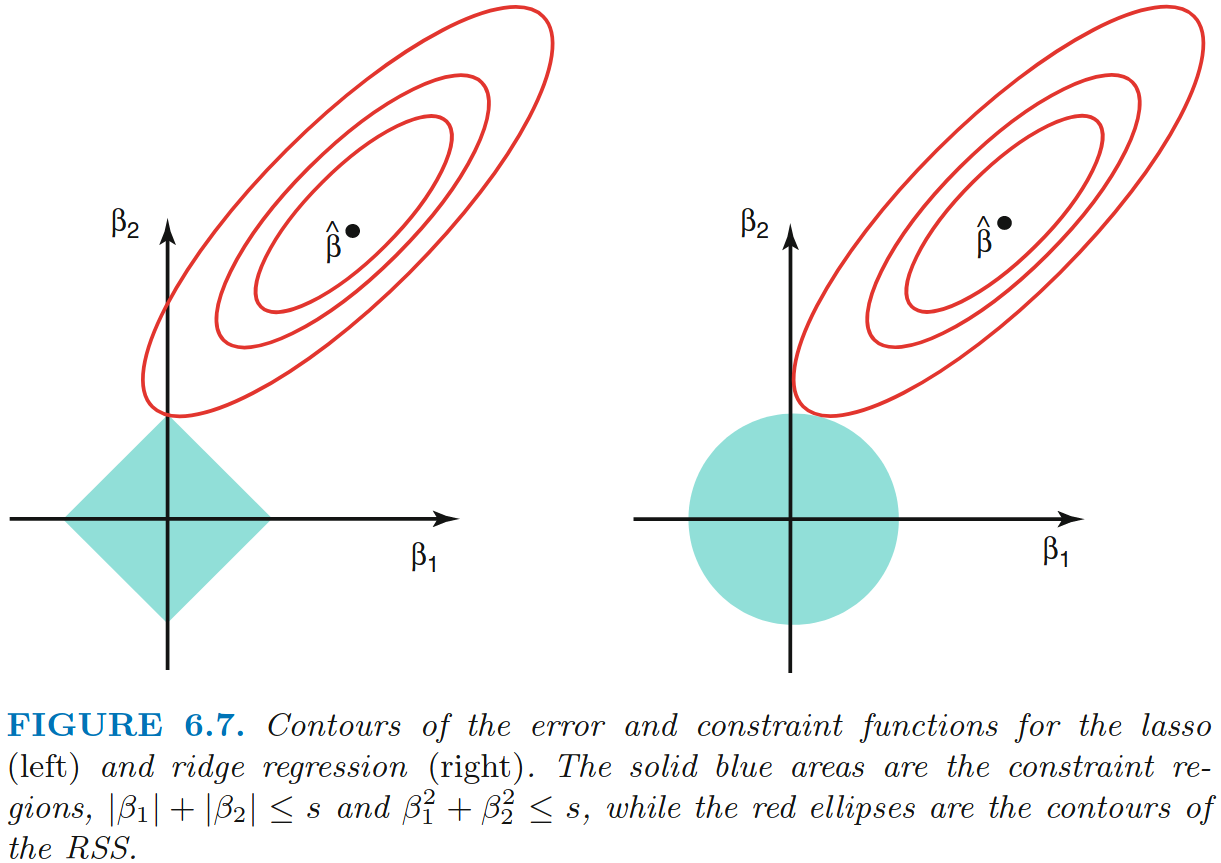

In [ ]:
from sklearn.linear_model import ElasticNetCV
ElasticNetCV?

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 10, 100)
l1_coeffs = np.linspace(0, 1, 30)

logit_searcher = ElasticNetCV(
    alphas=c_values, l1_ratio=l1_coeffs,
    cv=skf, verbose=1, n_jobs=-1
)
logit_searcher.fit(X_poly, y)

In [ ]:
print(f'Best l1 ratio: {logit_searcher.l1_ratio_}, best alpha: {logit_searcher.alpha_}')

In [ ]:
print('Elastic net accuracy on training set', logit_searcher.score(X_poly, y))

# Упражнение
Lasso-регрессия может быть использована для отбора признаков. Если коэффициент регрессии становится маленьким, мы можем исключить его из подмножества признаков и строить модель только на тех признаках, которые соответствуют большим коэффициентам.

1. Настройте Lasso-регрессию и получите коэффициенты с абсолютными значениями больше 0,001.
2. Настройте Ridge-регрессию, используя только отобранные признаки.
3. Настройте Lasso-регрессию, используя только отобранные признаки.
4. Сравните полученные результаты с предыдущими: дает ли использование отбора признаков более высокую точность?
5. Сравните результаты с Elastic Net регрессией.